In [1]:
import pandas as pd
import patsy as pt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
import re
import pymc3 as pm
import matplotlib.ticker as tk
import re
from sklearn.model_selection import StratifiedKFold
import pickle

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


## Import data

In [2]:
df = pd.read_csv('outputs/ala1_trials_clean.csv')
df = df.rename(columns={'project_name': 'basis', 'cluster__n_clusters': 'n', 'test_mean': 'y'}).\
loc[:, ['basis', 'y', 'n']]

## Scale predictors



In [3]:
to_log = ['n']
for col in to_log: 
    df.loc[:, col] = np.log(df[col])

to_scale = ['n']
scaler = preprocessing.MinMaxScaler()
vars_scaled = pd.DataFrame(scaler.fit_transform(df.loc[:, to_scale]), columns=[x+'_s' for x in to_scale])
df = df.join(vars_scaled)
df.T

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
basis,psi,rmsd,phipsi,phipsi,phi,positions,rmsd,phi,psi,positions,...,positions,phipsi,phipsi,positions,phipsi,positions,phipsi,positions,positions,positions
y,1.79637,1.70957,3.27798,3.28693,1.98877,3.29715,1.70869,1.98756,1.79831,3.16998,...,3.31788,3.30056,3.29722,3.32348,3.29749,3.33242,3.31647,2.94608,3.31237,3.08385
n,4.34381,6.31716,4.57471,4.55388,5.89164,6.08677,6.84801,5.1299,4.56435,3.49651,...,5.88332,5.14749,6.48616,6.19441,6.42487,6.86171,5.1299,3.13549,6.63726,3.3673
n_s,0.40961,0.864007,0.46278,0.457982,0.766024,0.810956,0.986242,0.59062,0.460393,0.214506,...,0.764108,0.594672,0.902921,0.83574,0.888808,0.989398,0.59062,0.131377,0.937714,0.184753


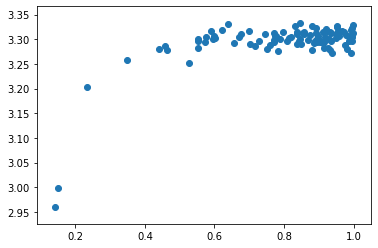

In [4]:
x = df.loc[df['basis']=='phipsi', 'n_s']
y = df.loc[df['basis']=='phipsi', 'y']
plt.scatter(x, y)

## Create design matrix

In [5]:
y = df.loc[:, 'y']
X = df.loc[:, df.columns.difference(['y'])]
X_c = pt.dmatrix('~ 0 + n_s + C(basis)', data=df, return_type='dataframe')
X_c = X_c.rename(columns=lambda x: re.sub('C|\\(|\\)|\\[|\\]','',x))

## Model fitting functions

In [6]:
def gamma(alpha, beta):
    def g(x):
        return pm.Gamma(x, alpha=alpha, beta=beta)
    return g

def hcauchy(beta):
    def g(x):
        return pm.HalfCauchy(x, beta=beta)
    return g


def fit_model_1(y, X, kernel_type='rbf'):
    """
    function to return a pymc3 model
    y : dependent variable
    X : independent variables
    prop_Xu : number of inducing varibles to use
    
    X, y are dataframes. We'll use the column names. 
    """
    with pm.Model() as model:
        # Covert arrays
        X_a = X.values
        y_a = y.values
        X_cols = list(X.columns)
        
        # Globals
        prop_Xu = 0.1 # proportion of observations to use as inducing variables
        l_prior = gamma(1, 0.05)
        eta_prior = hcauchy(2)
        sigma_prior = hcauchy(2)

        # Kernels
        # 3 way interaction
        eta = eta_prior('eta')
        cov = eta**2
        for i in range(X_a.shape[1]):
            var_lab = 'l_'+X_cols[i]
            if kernel_type=='RBF':
                cov = cov*pm.gp.cov.ExpQuad(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='Exponential':
                cov = cov*pm.gp.cov.Exponential(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='M52':
                cov = cov*pm.gp.cov.Matern52(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='M32':
                cov = cov*pm.gp.cov.Matern32(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])

        # Covariance model
        cov_tot = cov 

        # Model
        gp = pm.gp.MarginalSparse(cov_func=cov_tot, approx="FITC")

        # Noise model
        sigma_n =sigma_prior('sigma_n')

        # Inducing variables
        num_Xu = int(X_a.shape[0]*prop_Xu)
        Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X_a)

        # Marginal likelihood
        y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a,Xu=Xu, noise=sigma_n)
        mp = pm.find_MAP()
        
    return gp, mp, model

## Main testing loop

This will loop through the kernels to get cross - validated MSLL and SMSE.  Occaisionally a fold won't converge so the algo gets three attempt to restart (

In [7]:
# Inputs
kernels =  ['RBF', 'M52', 'M32', 'Exponential' ]

# Outputs
pred_dfs = []

# iterator
max_restarts = 3
for i in range(len(kernels)):
    print(kernels[i])
    
    converged = False
    n_restarts = 0
    while (not converged) and (n_restarts < max_restarts):
        
        # instantiate a new cv-er to ensure folds are different each loop through. 
        kf = StratifiedKFold(n_splits=10)
        
        # loop through folds
        for idx, (train_idx, test_idx) in enumerate(kf.split(X.values, X['basis'])):
            print('\tfold: {}'.format(idx))
            
            # subset dataframes for training and testin
            y_train = y.iloc[train_idx]
            X_train = X_c.iloc[train_idx, :]

            y_test = y.iloc[test_idx]
            X_test = X_c.iloc[test_idx, :]  
            
            try: 
                # Fit gp model
                gp, mp, model = fit_model_1(y=y_train, X=X_train, kernel_type=kernels[i])
                
                # Get predictions 
                with model:
                    # predict latent
                    mu, var = gp.predict(X_test.values, point=mp, diag=True,pred_noise=False)
                    sd_f = np.sqrt(var)

                    # predict target (includes noise)
                    _, var = gp.predict(X_test.values, point=mp, diag=True,pred_noise=True)
                    sd_y = np.sqrt(var)
                    
                # log results    
                res = pd.DataFrame({'f_pred': mu, 'sd_f': sd_f, 'sd_y': sd_y, 'y': y_test.values})
                res.loc[:, 'kernel'] = kernels[i]
                res.loc[:, 'fold_num'] = idx

                pred_dfs.append(pd.concat([X_test.reset_index(), res.reset_index()], axis=1))
            
            except: 
                # break without possibility of reaching convergence
                n_restarts += 1
                
                break

            # convergence criterion - must have got this far on the last fold: 
            if idx == kf.n_splits-1:
                converged = True
        

pred_dfs = pd.concat(pred_dfs)

RBF
	fold: 0


WARNING (theano.gof.compilelock): Overriding existing lock by dead process '10587' (I am process '30102')
/Users/robertarbon/opt/miniconda3/envs/analysis/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/robertarbon/opt/miniconda3/envs/analysis/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/robertarbon/opt/miniconda3/envs/analysis/lib/python3.6/site-packages/theano

	fold: 1


/Users/robertarbon/opt/miniconda3/envs/analysis/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = 1,244.6, ||grad|| = 0.006564: 100%|██████████| 62/62 [00:00<00:00, 107.01it/s]  


	fold: 2


logp = 1,244.9, ||grad|| = 0.19627: 100%|██████████| 45/45 [00:00<00:00, 104.47it/s]  


	fold: 3


logp = 1,323.7, ||grad|| = 0.044071: 100%|██████████| 65/65 [00:00<00:00, 108.84it/s]       


	fold: 4


logp = 1,298.5, ||grad|| = 0.090352: 100%|██████████| 56/56 [00:00<00:00, 97.46it/s]  


	fold: 5


logp = 1,056.5, ||grad|| = 178.83:   0%|          | 22/5000 [00:00<02:06, 39.34it/s]


	fold: 0


/Users/robertarbon/opt/miniconda3/envs/analysis/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = 1,313, ||grad|| = 0.028794: 100%|██████████| 63/63 [00:00<00:00, 86.89it/s]    


	fold: 1


logp = 1,244.4, ||grad|| = 0.0093812: 100%|██████████| 63/63 [00:00<00:00, 105.47it/s]  


	fold: 2


logp = 1,239.2, ||grad|| = 34.452: 100%|██████████| 295/295 [00:03<00:00, 87.04it/s]  


	fold: 3


logp = 1,325.2, ||grad|| = 0.016906: 100%|██████████| 62/62 [00:00<00:00, 105.36it/s]  


	fold: 4


logp = 1,297.4, ||grad|| = 0.6089: 100%|██████████| 56/56 [00:00<00:00, 93.12it/s]   


	fold: 5


logp = 1,286.1, ||grad|| = 0.017637: 100%|██████████| 73/73 [00:00<00:00, 78.90it/s]  


	fold: 6


logp = 1,271, ||grad|| = 0.042828: 100%|██████████| 66/66 [00:00<00:00, 109.85it/s]  


	fold: 7


logp = 1,307.4, ||grad|| = 0.01912: 100%|██████████| 74/74 [00:01<00:00, 61.94it/s]  


	fold: 8


logp = 1,308, ||grad|| = 0.014383: 100%|██████████| 62/62 [00:00<00:00, 80.03it/s]  


	fold: 9


logp = 1,307.4, ||grad|| = 0.048283: 100%|██████████| 69/69 [00:00<00:00, 78.61it/s]  


M52
	fold: 0


/Users/robertarbon/opt/miniconda3/envs/analysis/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/robertarbon/opt/miniconda3/envs/analysis/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
  0%|          | 0/5000 [00:00<?, ?it/s]/Users/robertarbon/opt/miniconda3/envs/analysis/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence f

	fold: 1


logp = 1,321.8, ||grad|| = 0.14287: 100%|██████████| 58/58 [00:01<00:00, 57.99it/s]  


	fold: 2


logp = 1,342.7, ||grad|| = 0.376: 100%|██████████| 89/89 [00:01<00:00, 63.63it/s]    


	fold: 3


logp = 1,323, ||grad|| = 0.04486: 100%|██████████| 79/79 [00:01<00:00, 50.69it/s]   


	fold: 4


logp = 1,331.6, ||grad|| = 0.15677: 100%|██████████| 81/81 [00:01<00:00, 56.83it/s]  


	fold: 5


logp = 1,313.3, ||grad|| = 0.066471: 100%|██████████| 82/82 [00:01<00:00, 66.14it/s]  


	fold: 6


logp = 1,353.2, ||grad|| = 0.003182: 100%|██████████| 52/52 [00:00<00:00, 59.46it/s]  


	fold: 7


logp = 1,328.2, ||grad|| = 0.053146: 100%|██████████| 66/66 [00:01<00:00, 54.15it/s]  


	fold: 8


logp = 1,325.7, ||grad|| = 0.025081: 100%|██████████| 83/83 [00:01<00:00, 59.29it/s]  


	fold: 9


logp = 1,347.4, ||grad|| = 0.28135: 100%|██████████| 66/66 [00:01<00:00, 51.46it/s]  


M32
	fold: 0


/Users/robertarbon/opt/miniconda3/envs/analysis/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
  0%|          | 0/5000 [00:00<?, ?it/s]/Users/robertarbon/opt/miniconda3/envs/analysis/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = 1,339.7, ||grad|| = 0.18072: 100%|██████████| 70/70 [00:01<00:00, 60.86it/s]  


	fold: 1


logp = 1,326.7, ||grad|| = 0.010916: 100%|██████████| 80/80 [00:01<00:00, 63.70it/s]  


	fold: 2


logp = 1,320.9, ||grad|| = 0.70329: 100%|██████████| 49/49 [00:00<00:00, 68.13it/s]  


	fold: 3


logp = 1,317.5, ||grad|| = 0.08035: 100%|██████████| 41/41 [00:00<00:00, 65.36it/s]  


	fold: 4


logp = 1,310, ||grad|| = 0.30234: 100%|██████████| 50/50 [00:00<00:00, 63.05it/s]   


	fold: 5


logp = 1,290.6, ||grad|| = 0.44573: 100%|██████████| 41/41 [00:00<00:00, 68.58it/s]  


	fold: 6


logp = 1,320.6, ||grad|| = 0.070957: 100%|██████████| 84/84 [00:01<00:00, 58.86it/s]  


	fold: 7


logp = 1,322.1, ||grad|| = 0.18479: 100%|██████████| 55/55 [00:01<00:00, 53.07it/s]  


	fold: 8


logp = 1,324, ||grad|| = 0.35389: 100%|██████████| 78/78 [00:01<00:00, 56.96it/s]   


	fold: 9


logp = 1,340.5, ||grad|| = 0.10576: 100%|██████████| 85/85 [00:01<00:00, 64.71it/s]  


Exponential
	fold: 0


/Users/robertarbon/opt/miniconda3/envs/analysis/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
  0%|          | 0/5000 [00:00<?, ?it/s]/Users/robertarbon/opt/miniconda3/envs/analysis/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = 1,279.7, ||grad|| = 0.79774: 100%|██████████| 31/31 [00:00<00:00, 72.57it/s]  


	fold: 1


logp = 1,243.5, ||grad|| = 0.088535: 100%|██████████| 50/50 [00:00<00:00, 81.10it/s]  


	fold: 2


logp = 1,220.3, ||grad|| = 0.13338: 100%|██████████| 49/49 [00:01<00:00, 41.74it/s]  


	fold: 3


logp = 1,206, ||grad|| = 0.24638: 100%|██████████| 40/40 [00:00<00:00, 84.59it/s]   


	fold: 4


logp = 1,276.2, ||grad|| = 0.35217: 100%|██████████| 45/45 [00:00<00:00, 76.92it/s]  


	fold: 5


logp = 1,203.6, ||grad|| = 0.18935: 100%|██████████| 40/40 [00:00<00:00, 84.54it/s]  


	fold: 6


logp = 1,235.6, ||grad|| = 0.23059: 100%|██████████| 57/57 [00:00<00:00, 81.63it/s]  


	fold: 7


logp = 1,231.1, ||grad|| = 0.17443: 100%|██████████| 49/49 [00:00<00:00, 56.02it/s]  


	fold: 8


logp = 1,225.3, ||grad|| = 0.0092721: 100%|██████████| 74/74 [00:00<00:00, 84.75it/s]  


	fold: 9


logp = 1,274.1, ||grad|| = 0.87006: 100%|██████████| 47/47 [00:00<00:00, 79.13it/s]  


## Evaluate kernels

In [8]:
def ll(f_pred, sigma_pred, y_true):
    # log predictive density
    tmp = 0.5*np.log(2*np.pi*sigma_pred**2)
    tmp += (f_pred-y_true)**2/(2*sigma_pred**2)
    return tmp

null_mu = np.mean(y)
null_sd = np.std(y)

sll = ll(pred_dfs['f_pred'], pred_dfs['sd_y'], pred_dfs['y'])
sll = sll - ll(null_mu, null_sd, pred_dfs['y'])
pred_dfs['msll'] = sll
pred_dfs['smse'] = (pred_dfs['f_pred']-pred_dfs['y'])**2/np.var(y)
pred_dfs.to_pickle('outputs/kernel_cv_fits_logged.p')

msll = pred_dfs.groupby(['kernel'])['msll'].mean()
smse = pred_dfs.groupby(['kernel'])['smse'].mean()

summary = pd.DataFrame(smse).join(other=pd.DataFrame(msll), on=['kernel'], how='left')
summary.to_csv('outputs/kernel_cv_fits_logged_summary.csv')

In [10]:
summary

,smse,msll
kernel,,
Exponential,0.001238,-3.996293
M32,0.000993,-4.171170
M52,0.000678,-4.236903
RBF,0.001077,-4.089169
